In [1]:
import sys

sys.path.append('../utils')

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.sparse import csr_array
from typing import Union, Optional
from typing import Union, List
from utils import check_index, adjacencyplot
from os.path import join as pjoin
import itertools
import scipy.spatial as spatial

In [3]:
## UTILS
def filter_synapse_table(synapse_table: pd.DataFrame,
                         pre_root_ids=None,
                         post_root_ids=None):
    """Filter synapse table by pre and post root ids.

    Args:
        synapse_table: synapse table with pre_pt_root_ids and post_pt_root_ids as pd.DataFrame
        pre_root_ids: np.ndarray, list or pd.Series if root_ids to filter on the presynaptic side
        post_root_ids: np.ndarray, list or pd.Series if root_ids to filter on the postsynaptic side

    Returns:
        synapse_table: filtered synapse table
    """

    if pre_root_ids is not None:
        assert isinstance(
            pre_root_ids, (np.ndarray, list, pd.core.series.Series)
        ), (f"IDs have to be of type np.ndarray, list or pd.Series; got {type(pre_root_ids)}"
           )
        pre_mask = np.isin(synapse_table["pre_pt_root_id"], pre_root_ids)
    else:
        pre_mask = np.ones(len(synapse_table), dtype=bool)

    if post_root_ids is not None:
        assert isinstance(
            post_root_ids, (np.ndarray, list, pd.core.series.Series)
        ), (f"IDs have to be of type np.ndarray, list or pd.Series; got {type(pre_root_ids)}"
           )
        post_mask = np.isin(synapse_table["post_pt_root_id"], post_root_ids)
    else:
        post_mask = np.ones(len(synapse_table), dtype=bool)

    return synapse_table[pre_mask & post_mask]


def calculate_neuronal_distance(
        pre_cell_df: pd.DataFrame,
        post_cell_df: pd.DataFrame,
        distance_type: Union[str, List[str]] = "3d") -> pd.DataFrame:
    """
    Calculate pairwise distances between pre- and post-synaptic cells.
    
    Parameters
    ----------
    pre_cell_df : pd.DataFrame
        DataFrame containing presynaptic cell information with position columns
    post_cell_df : pd.DataFrame
        DataFrame containing postsynaptic cell information with position columns
    distance_type : str or list of str, default "3d"
        Type(s) of distance to calculate. Options: "lateral", "vertical", "3d"
        
    Returns
    -------
    pd.DataFrame
        DataFrame with columns for cell ID pairs and calculated distances
    """
    # Normalize distance_type to list
    if isinstance(distance_type, str):
        distance_type = [distance_type]

    # Define column mappings for different distance types
    distance_column_map = {
        "lateral": [
            "pt_position_trform_x",
            "pt_position_trform_z",
        ],
        "vertical": ["pt_position_trform_y"],
        "3d": [
            "pt_position_trform_x",
            "pt_position_trform_y",
            "pt_position_trform_z",
        ]
    }

    # Validate distance types
    invalid_types = set(distance_type) - set(distance_column_map.keys())
    if invalid_types:
        raise ValueError(f"Unknown distance type(s): {invalid_types}. "
                         f"Valid options: {list(distance_column_map.keys())}")

    # Calculate distances for each type
    distances = {}
    for dist_type in distance_type:
        dist_columns = distance_column_map[dist_type]

        pre_positions = pre_cell_df[dist_columns].values
        post_positions = post_cell_df[dist_columns].values

        pairwise_distances = spatial.distance.cdist(pre_positions,
                                                    post_positions)
        distances[dist_type] = pairwise_distances.flatten()

    id_pairs = list(
        itertools.product(pre_cell_df["pt_root_id"],
                          post_cell_df["pt_root_id"]))
    result_df = pd.DataFrame(id_pairs,
                             columns=['pre_pt_root_id', 'post_pt_root_id'])

    # Add distance columns
    for dist_type, dist_values in distances.items():
        result_df[f'distance_{dist_type}'] = dist_values

    # Remove self-connections (where pre and post IDs are the same)
    result_df = result_df[result_df['pre_pt_root_id'] !=
                          result_df['post_pt_root_id']]

    return result_df


def add_distance_columns(df: pd.DataFrame, distance_type: str | list[str]):
    """
    Add distance columns to a DataFrame containing cell pairs.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing cell pairs with pre_ and post_ position columns
    distance_type : str or list of str, default "3d"
        Type(s) of distance to calculate. Options: "lateral", "vertical", "3d"
        
    Returns
    -------
    pd.DataFrame
        DataFrame with added distance columns
    """
    # Normalize distance_type to list
    if isinstance(distance_type, str):
        distance_type = [distance_type]

    # Define column mappings for different distance types
    distance_column_map = {
        "lateral": [
            "pt_position_trform_x",
            "pt_position_trform_z",
        ],
        "vertical": ["pt_position_trform_y"],
        "3d": [
            "pt_position_trform_x",
            "pt_position_trform_y",
            "pt_position_trform_z",
        ]
    }

    # Validate distance types
    invalid_types = set(distance_type) - set(distance_column_map.keys())
    if invalid_types:
        raise ValueError(f"Unknown distance type(s): {invalid_types}. "
                         f"Valid options: {list(distance_column_map.keys())}")

    # Make a copy to avoid modifying the original DataFrame
    result_df = df.copy()

    # Calculate distances for each type
    for dist_type in distance_type:
        dist_columns = distance_column_map[dist_type]

        # Get pre and post position columns
        pre_columns = [f"pre_{col}" for col in dist_columns]
        post_columns = [f"post_{col}" for col in dist_columns]

        # Calculate distance row by row
        pre_positions = result_df[pre_columns].values
        post_positions = result_df[post_columns].values

        # Calculate Euclidean distance for each row
        distances = np.sqrt(np.sum((pre_positions - post_positions)**2, axis=1))

        # Add distance column
        result_df[f'distance_{dist_type}'] = distances

    return result_df


def create_pairs_df(df):

    # Do a cartesian product (self-merge on nothing)
    df_pre = df.add_prefix("pre_")
    df_post = df.add_prefix("post_")
    df_pairs = df_pre.merge(df_post, how="cross")

    # Remove self-pairs
    df_pairs = df_pairs[df_pairs["pre_id"] != df_pairs["post_id"]].reset_index(
        drop=True)

    return df_pairs

In [4]:
data_dir = '/Users/rodrigo.gonzalezlaiz/Desktop/v1dd_1196'
mat_version = '1196'

In [5]:
# Loads cells with axon and dendrite proofreading
dendrite_proof_root_ids = np.load(
    pjoin(data_dir, f"proofread_dendrite_list_{mat_version}.npy"))
axon_proof_root_ids = np.load(
    pjoin(data_dir, f"proofread_axon_list_{mat_version}.npy"))

# get the ids of all proofread cells with both axon and dendrite proofreading
proof_root_ids = axon_proof_root_ids[np.isin(axon_proof_root_ids,
                                             dendrite_proof_root_ids)]

print(
    f"There are {len(dendrite_proof_root_ids)} cells with acceptable dendrites, and {len(axon_proof_root_ids)} cells with axon proofreading"
)
print(
    f"The number of cells with usable axons and dendrites is: {len(proof_root_ids)}"
)


There are 63986 cells with acceptable dendrites, and 1210 cells with axon proofreading
The number of cells with usable axons and dendrites is: 1148


In [6]:
cell_df = pd.read_feather(
    f"{data_dir}/soma_and_cell_type_{mat_version}.feather")
cell_df[[col for col in cell_df.columns if "position" in col]] /= 1000.

In [7]:
# note (rodrigo): in the workshop they only use the axon proofread cells (1164 cells)
cell_df_proofread = cell_df[
    np.isin(cell_df['pt_root_id'], axon_proof_root_ids) &
    np.isin(cell_df['pt_root_id'], dendrite_proof_root_ids)].reset_index(
        drop=True)
# cell_df_proofread_l3 = cell_df_proofread[cell_df_proofread["cell_type"] ==
#                                          "L3-IT"]

In [8]:
cell_df.shape

(207455, 11)

In [9]:
cell_df_proofread_pairs = create_pairs_df(cell_df_proofread)
cell_df_proofread_pairs = add_distance_columns(cell_df_proofread_pairs,
                                               distance_type=["3d", 'vertical'])


In [10]:
cell_df_proofread_pairs

,pre_id,pre_pt_position_x,pre_pt_position_y,pre_pt_position_z,pre_pt_position_trform_x,pre_pt_position_trform_y,pre_pt_position_trform_z,pre_pt_root_id,pre_volume,pre_cell_type_coarse,...,post_pt_position_z,post_pt_position_trform_x,post_pt_position_trform_y,post_pt_position_trform_z,post_pt_root_id,post_volume,post_cell_type_coarse,post_cell_type,distance_3d,distance_vertical
0,293764,878.665,697.702,245.475,-17.654153,354.663188,-51.618076,864691132625300120,231.369357,E,...,325.260,-67.856489,415.829186,13.006444,864691132710501931,453.768761,E,L5-IT,102.165956,61.165998
1,293764,878.665,697.702,245.475,-17.654153,354.663188,-51.618076,864691132625300120,231.369357,E,...,294.075,-145.995980,274.794268,19.379727,864691132923215329,336.579200,I,DTC,167.007057,79.868920
2,293764,878.665,697.702,245.475,-17.654153,354.663188,-51.618076,864691132625300120,231.369357,E,...,240.210,-37.633020,355.616431,-57.338047,864691132616354625,260.410740,I,ITC,20.803410,0.953243
3,293764,878.665,697.702,245.475,-17.654153,354.663188,-51.618076,864691132625300120,231.369357,E,...,262.935,-69.027466,503.380292,-79.655916,864691132999200949,352.843100,E,L5-IT,159.819007,148.717104
4,293764,878.665,697.702,245.475,-17.654153,354.663188,-51.618076,864691132625300120,231.369357,E,...,173.250,17.492220,397.154153,-139.157779,864691132657293527,305.316600,I,DTC,103.459892,42.490965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1316751,277788,853.833,547.235,263.385,-23.541352,212.865030,-0.825611,864691132653866455,331.094581,E,...,382.545,67.043560,325.154772,98.687317,864691132849454803,420.918766,I,PTC,175.263901,112.289743
1316752,277788,853.833,547.235,263.385,-23.541352,212.865030,-0.825611,864691132653866455,331.094581,E,...,189.495,257.331255,218.305414,-78.400099,864691132819642111,159.295394,I,ITC,291.439222,5.440384
1316753,277788,853.833,547.235,263.385,-23.541352,212.865030,-0.825611,864691132653866455,331.094581,E,...,394.650,17.544598,553.562858,34.298148,864691132679146333,325.794498,E,L6-IT,344.959046,340.697828
1316754,277788,853.833,547.235,263.385,-23.541352,212.865030,-0.825611,864691132653866455,331.094581,E,...,316.125,3.578300,473.261098,-13.876769,864691132663975748,457.329970,E,L5-IT,262.129587,260.396068


In [11]:
cell_df_proofread_pairs.shape

(1316756, 24)

In [12]:
#NOTE(Rodrigo): proof_root_ids contains both "presynaptic" and "postsynaptic" root ids.
# only use synapses with proofread cells

syn_df = pd.read_feather(
    f"{data_dir}/syn_df_all_to_proofread_to_all_{mat_version}.feather")

proofread_syn_df = filter_synapse_table(syn_df, proof_root_ids,
                                        proof_root_ids).reset_index(drop=True)

print(syn_df.shape, proofread_syn_df.shape)

(8204497, 13) (195304, 13)


In [13]:
# Get unique pre-post pairs from analysis_syn_df
connected_pairs = proofread_syn_df[['pre_pt_root_id',
                                    'post_pt_root_id']].drop_duplicates()

# Create a set of tuples for faster lookup
connected_pairs_set = set(
    zip(connected_pairs['pre_pt_root_id'], connected_pairs['post_pt_root_id']))

cell_df_proofread_pairs['is_connected'] = cell_df_proofread_pairs.apply(
    lambda row:
    (row['pre_pt_root_id'], row['post_pt_root_id']) in connected_pairs_set,
    axis=1)

print(f"Total pairs in distance_df: {len(cell_df_proofread_pairs)}")
print(f"Connected pairs: {cell_df_proofread_pairs['is_connected'].sum()}")
print(f"Unique connected pairs in analysis_syn_df: {len(connected_pairs)}")

percetange_conntected = len(connected_pairs) / len(cell_df_proofread_pairs)
print(f"Percentage of connected pairs: {percetange_conntected*100:.2F}%")

Total pairs in distance_df: 1316756
Connected pairs: 90845
Unique connected pairs in analysis_syn_df: 90845
Percentage of connected pairs: 6.90%


In [14]:
cell_df_proofread_pairs

,pre_id,pre_pt_position_x,pre_pt_position_y,pre_pt_position_z,pre_pt_position_trform_x,pre_pt_position_trform_y,pre_pt_position_trform_z,pre_pt_root_id,pre_volume,pre_cell_type_coarse,...,post_pt_position_trform_x,post_pt_position_trform_y,post_pt_position_trform_z,post_pt_root_id,post_volume,post_cell_type_coarse,post_cell_type,distance_3d,distance_vertical,is_connected
0,293764,878.665,697.702,245.475,-17.654153,354.663188,-51.618076,864691132625300120,231.369357,E,...,-67.856489,415.829186,13.006444,864691132710501931,453.768761,E,L5-IT,102.165956,61.165998,False
1,293764,878.665,697.702,245.475,-17.654153,354.663188,-51.618076,864691132625300120,231.369357,E,...,-145.995980,274.794268,19.379727,864691132923215329,336.579200,I,DTC,167.007057,79.868920,False
2,293764,878.665,697.702,245.475,-17.654153,354.663188,-51.618076,864691132625300120,231.369357,E,...,-37.633020,355.616431,-57.338047,864691132616354625,260.410740,I,ITC,20.803410,0.953243,True
3,293764,878.665,697.702,245.475,-17.654153,354.663188,-51.618076,864691132625300120,231.369357,E,...,-69.027466,503.380292,-79.655916,864691132999200949,352.843100,E,L5-IT,159.819007,148.717104,False
4,293764,878.665,697.702,245.475,-17.654153,354.663188,-51.618076,864691132625300120,231.369357,E,...,17.492220,397.154153,-139.157779,864691132657293527,305.316600,I,DTC,103.459892,42.490965,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1316751,277788,853.833,547.235,263.385,-23.541352,212.865030,-0.825611,864691132653866455,331.094581,E,...,67.043560,325.154772,98.687317,864691132849454803,420.918766,I,PTC,175.263901,112.289743,False
1316752,277788,853.833,547.235,263.385,-23.541352,212.865030,-0.825611,864691132653866455,331.094581,E,...,257.331255,218.305414,-78.400099,864691132819642111,159.295394,I,ITC,291.439222,5.440384,False
1316753,277788,853.833,547.235,263.385,-23.541352,212.865030,-0.825611,864691132653866455,331.094581,E,...,17.544598,553.562858,34.298148,864691132679146333,325.794498,E,L6-IT,344.959046,340.697828,False
1316754,277788,853.833,547.235,263.385,-23.541352,212.865030,-0.825611,864691132653866455,331.094581,E,...,3.578300,473.261098,-13.876769,864691132663975748,457.329970,E,L5-IT,262.129587,260.396068,False


In [15]:
cell_df_proofread_pairs = cell_df_proofread_pairs.dropna(
    subset=['pre_cell_type', 'post_cell_type'])
cell_df_proofread_pairs

,pre_id,pre_pt_position_x,pre_pt_position_y,pre_pt_position_z,pre_pt_position_trform_x,pre_pt_position_trform_y,pre_pt_position_trform_z,pre_pt_root_id,pre_volume,pre_cell_type_coarse,...,post_pt_position_trform_x,post_pt_position_trform_y,post_pt_position_trform_z,post_pt_root_id,post_volume,post_cell_type_coarse,post_cell_type,distance_3d,distance_vertical,is_connected
0,293764,878.665,697.702,245.475,-17.654153,354.663188,-51.618076,864691132625300120,231.369357,E,...,-67.856489,415.829186,13.006444,864691132710501931,453.768761,E,L5-IT,102.165956,61.165998,False
1,293764,878.665,697.702,245.475,-17.654153,354.663188,-51.618076,864691132625300120,231.369357,E,...,-145.995980,274.794268,19.379727,864691132923215329,336.579200,I,DTC,167.007057,79.868920,False
2,293764,878.665,697.702,245.475,-17.654153,354.663188,-51.618076,864691132625300120,231.369357,E,...,-37.633020,355.616431,-57.338047,864691132616354625,260.410740,I,ITC,20.803410,0.953243,True
3,293764,878.665,697.702,245.475,-17.654153,354.663188,-51.618076,864691132625300120,231.369357,E,...,-69.027466,503.380292,-79.655916,864691132999200949,352.843100,E,L5-IT,159.819007,148.717104,False
4,293764,878.665,697.702,245.475,-17.654153,354.663188,-51.618076,864691132625300120,231.369357,E,...,17.492220,397.154153,-139.157779,864691132657293527,305.316600,I,DTC,103.459892,42.490965,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1316751,277788,853.833,547.235,263.385,-23.541352,212.865030,-0.825611,864691132653866455,331.094581,E,...,67.043560,325.154772,98.687317,864691132849454803,420.918766,I,PTC,175.263901,112.289743,False
1316752,277788,853.833,547.235,263.385,-23.541352,212.865030,-0.825611,864691132653866455,331.094581,E,...,257.331255,218.305414,-78.400099,864691132819642111,159.295394,I,ITC,291.439222,5.440384,False
1316753,277788,853.833,547.235,263.385,-23.541352,212.865030,-0.825611,864691132653866455,331.094581,E,...,17.544598,553.562858,34.298148,864691132679146333,325.794498,E,L6-IT,344.959046,340.697828,False
1316754,277788,853.833,547.235,263.385,-23.541352,212.865030,-0.825611,864691132653866455,331.094581,E,...,3.578300,473.261098,-13.876769,864691132663975748,457.329970,E,L5-IT,262.129587,260.396068,False


In [22]:
df.columns

Index(['pre_id', 'pre_pt_position_x', 'pre_pt_position_y', 'pre_pt_position_z',
       'pre_pt_position_trform_x', 'pre_pt_position_trform_y',
       'pre_pt_position_trform_z', 'pre_pt_root_id', 'pre_volume',
       'pre_cell_type_coarse', 'pre_cell_type', 'post_id',
       'post_pt_position_x', 'post_pt_position_y', 'post_pt_position_z',
       'post_pt_position_trform_x', 'post_pt_position_trform_y',
       'post_pt_position_trform_z', 'post_pt_root_id', 'post_volume',
       'post_cell_type_coarse', 'post_cell_type', 'distance_3d',
       'distance_vertical', 'is_connected', 'dist_bin'],
      dtype='object')

In [ ]:
df = cell_df_proofread_pairs.copy()

# Step 1: make distance bins
bins = np.arange(0, df['distance_3d'].max(), 50)  # 0-50, 50-100, ... µm
df['dist_bin'] = pd.cut(df['distance_3d'], bins=bins)

# Step 2: compute empirical probabilities
# p_connect represents the probability of connection within each group
# (pre_cell_type, post_cell_type, distance_bin), not across all groups
# So p_connect values don't need to sum to 1 - each is an independent probability
probs = (df.groupby([
    'pre_cell_type',
    'post_cell_type',
    'dist_bin',
])['is_connected'].mean().reset_index().rename(
    columns={'is_connected': 'p_connect'}))

# remove 0-probability connections
#probs = probs[probs['p_connect'] > 0]
#probs.loc[probs['p_connect'] == 0., 'p_connect'] = 1 * 10**-10

# Each p_connect value is the fraction of connected pairs within that specific
# (cell_type_pre, cell_type_post, distance_bin) combination
# These are conditional probabilities: P(connected | cell_types, distance_bin)

/var/folders/zh/r3ys8n591255r84b26zk70640000gn/T/ipykernel_18465/3575680188.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  probs = (df.groupby([


In [23]:
probs['pre_cell_type'].unique()

array(['DTC', 'ITC', 'L2-IT', 'L3-IT', 'L4-IT', 'L5-ET', 'L5-IT', 'L5-NP',
       'L6-CT', 'L6-IT', 'PTC', 'STC'], dtype=object)

In [18]:
rng = np.random.default_rng()


def build_surrogate(df, probs, fixed_counts=False, join_type='left'):
    df_null = df.merge(probs,
                       on=['pre_cell_type', 'post_cell_type', 'dist_bin'],
                       how=join_type)
    if not fixed_counts:
        # Binomial sampling
        df_null['is_connected_null'] = rng.binomial(1, df_null['p_connect'])
    else:
        # Fixed-count shuffle
        df_null['is_connected_null'] = 0
        for (ptype, ppost, dbin), group in df_null.groupby(
            ['pre_cell_type', 'post_cell_type', 'dist_bin']):
            n_edges = group['is_connected'].sum()  # observed count
            chosen = rng.choice(group.index, size=n_edges, replace=False)
            df_null.loc[chosen, 'is_connected_null'] = 1
    return df_null[df_null['is_connected_null'] == 1]


# Build 100 surrogates
nulls = [
    build_surrogate(df, probs, fixed_counts=False, join_type='inner')
    for _ in range(10)
]


In [51]:
cells_null = nulls[0][['pre_pt_root_id', 'post_pt_root_id']]

In [52]:
cells_null

,pre_pt_root_id,post_pt_root_id
12,864691132625300120,864691132594791991
32,864691132625300120,864691132680792915
34,864691132625300120,864691132741433380
36,864691132625300120,864691132901528570
78,864691132625300120,864691132767072268
...,...,...
1262146,864691132653866455,864691132701440756
1262148,864691132653866455,864691132656190716
1262156,864691132653866455,864691132710434049
1262167,864691132653866455,864691132986714208


In [53]:
property = proofread_syn_df.merge(cells_null,
                                  on=['pre_pt_root_id', 'post_pt_root_id'],
                                  how='inner')['size']

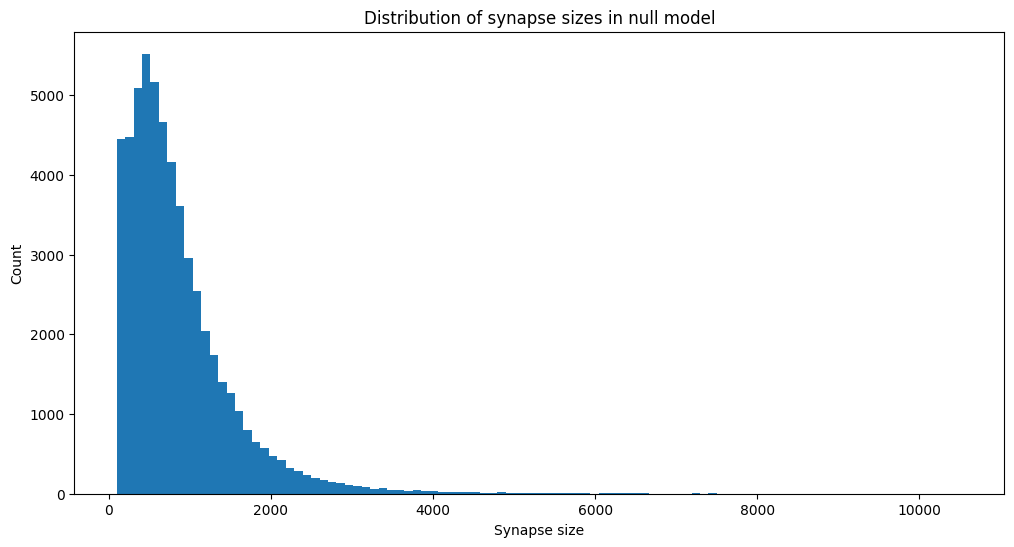

In [54]:
plt.figure(figsize=(12, 6))
plt.hist(property, bins=100)
plt.xlabel('Synapse size')
plt.ylabel('Count')
plt.title('Distribution of synapse sizes in null model')
plt.show()

In [55]:
property.mean()

858.1122813345356